# **Final Project for COGS 106 (61735) Fall 2023**
### **Group members:** Jessica Walters and Grace Dalton
### **Dataset:** Most Streamed Spotify Songs 2023 (https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data)
### **Research questions:** 
1. #### Can we predict how many streams on Spotify a song has based on its patterns of audio features (example variables: key, mode, danceability, valence, energy, acousticness, instrumentalness, liveliness, speechiness)?
2. #### Can we predict based on certain aspects of the song which streaming site (Spotify or Apple playlist) it would be more popular on?
3. #### Are the songs clustered based on any track features/release information?


# Import modules

In [193]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split

# Download, clean, and explore dataset

In [194]:
# download spotify data as dataframe
data = pd.read_csv('spotify-2023.csv', encoding='latin-1')
data.head()

track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703                  43  ...  125   B  Major   
1                 48  133716286                  48  ...   92  C#  Major   
2                113  140003974                  94  ...  138   F  Major   
3                100  800840817                 116  ...  170   A  Major   
4                 50  303236322                  84  ...  144   A  Minor   

  danceability_%  valence_% energy_% acousticness_%  instrumentalness_%  \
0             80         89       83             31                   0   
1             71         61       74              7                   0   
2             51         32       53             17                   0   
3             55         58       72             11                   0   
4             65         23       80             14                  63   

   liveness_%  speechiness_%  
0           8              4  
1          10              4  
2          31              6  
3          11             15  
4          11              6  

[5 rows x 24 columns]

In [195]:
# column names
data.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

### Dataset features
* track_name: Name of the song
* artist(s)_name: Name of the artist(s) of the song
* artist_count: Number of artists contributing to the song
* released_year: Year when the song was released
* released_month: Month when the song was released
* released_day: Day of the month when the song was released
* in_spotify_playlists: Number of Spotify playlists the song is included in
* in_spotify_charts: Presence and rank of the song on Spotify charts
* streams: Total number of streams on Spotify
* in_apple_playlists: Number of Apple Music playlists the song is included in
* in_apple_charts: Presence and rank of the song on Apple Music charts
* in_deezer_playlists: Number of Deezer playlists the song is included in
* in_deezer_charts: Presence and rank of the song on Deezer charts
* in_shazam_charts: Presence and rank of the song on Shazam charts
* bpm: Beats per minute, a measure of song tempo
* key: Key of the song
* mode: Mode of the song (major or minor)
* danceability_%: Percentage indicating how suitable the song is for dancing
* valence_%: Positivity of the song's musical content
* energy_%: Perceived energy level of the song
* acousticness_%: Amount of acoustic sound in the song
* instrumentalness_%: Amount of instrumental content in the song
* liveness_%: Presence of live performance elements
* speechiness_%: Amount of spoken words in the song

In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [197]:
# force streams into continuous variable
data['streams'] = pd.to_numeric(data['streams'], errors='coerce') #this way gets streams to show up on the heatmap in the next one (-jw)

In [198]:
data.describe()

artist_count  released_year  released_month  released_day  \
count    953.000000     953.000000      953.000000    953.000000   
mean       1.556139    2018.238195        6.033578     13.930745   
std        0.893044      11.116218        3.566435      9.201949   
min        1.000000    1930.000000        1.000000      1.000000   
25%        1.000000    2020.000000        3.000000      6.000000   
50%        1.000000    2022.000000        6.000000     13.000000   
75%        2.000000    2022.000000        9.000000     22.000000   
max        8.000000    2023.000000       12.000000     31.000000   

       in_spotify_playlists  in_spotify_charts       streams  \
count            953.000000         953.000000  9.520000e+02   
mean            5200.124869          12.009444  5.141374e+08   
std             7897.608990          19.575992  5.668569e+08   
min               31.000000           0.000000  2.762000e+03   
25%              875.000000           0.000000  1.416362e+08   
50%             2224.000000           3.000000  2.905309e+08   
75%             5542.000000          16.000000  6.738690e+08   
max            52898.000000         147.000000  3.703895e+09   

       in_apple_playlists  in_apple_charts  in_deezer_charts         bpm  \
count          953.000000       953.000000        953.000000  953.000000   
mean            67.812172        51.908709          2.666317  122.540399   
std             86.441493        50.630241          6.035599   28.057802   
min              0.000000         0.000000          0.000000   65.000000   
25%             13.000000         7.000000          0.000000  100.000000   
50%             34.000000        38.000000          0.000000  121.000000   
75%             88.000000        87.000000          2.000000  140.000000   
max            672.000000       275.000000         58.000000  206.000000   

       danceability_%   valence_%    energy_%  acousticness_%  \
count       953.00000  953.000000  953.000000      953.000000   
mean         66.96957   51.431270   64.279119       27.057712   
std          14.63061   23.480632   16.550526       25.996077   
min          23.00000    4.000000    9.000000        0.000000   
25%          57.00000   32.000000   53.000000        6.000000   
50%          69.00000   51.000000   66.000000       18.000000   
75%          78.00000   70.000000   77.000000       43.000000   
max          96.00000   97.000000   97.000000       97.000000   

       instrumentalness_%  liveness_%  speechiness_%  
count          953.000000  953.000000     953.000000  
mean             1.581322   18.213012      10.131165  
std              8.409800   13.711223       9.912888  
min              0.000000    3.000000       2.000000  
25%              0.000000   10.000000       4.000000  
50%              0.000000   12.000000       6.000000  
75%              0.000000   24.000000      11.000000  
max             91.000000   97.000000      64.000000

## Initial data cleaning

In [199]:
#check for duplicate data
data.duplicated().sum()

0

In [200]:
# drop null/missing data
data = data.dropna()

# check for leftover null data
data.isnull().sum()

track_name              0
artist(s)_name          0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64

In [201]:
# drop data columns of features we're not looking at
data = data.drop(['in_deezer_charts','in_deezer_playlists', 'in_shazam_charts'], axis=1)

In [202]:
# review dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 952
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            816 non-null    object 
 1   artist(s)_name        816 non-null    object 
 2   artist_count          816 non-null    int64  
 3   released_year         816 non-null    int64  
 4   released_month        816 non-null    int64  
 5   released_day          816 non-null    int64  
 6   in_spotify_playlists  816 non-null    int64  
 7   in_spotify_charts     816 non-null    int64  
 8   streams               816 non-null    float64
 9   in_apple_playlists    816 non-null    int64  
 10  in_apple_charts       816 non-null    int64  
 11  bpm                   816 non-null    int64  
 12  key                   816 non-null    object 
 13  mode                  816 non-null    object 
 14  danceability_%        816 non-null    int64  
 15  valence_%             8

## Exploring/Graphing Data

### Histograms

#### Graphs for Track Performance

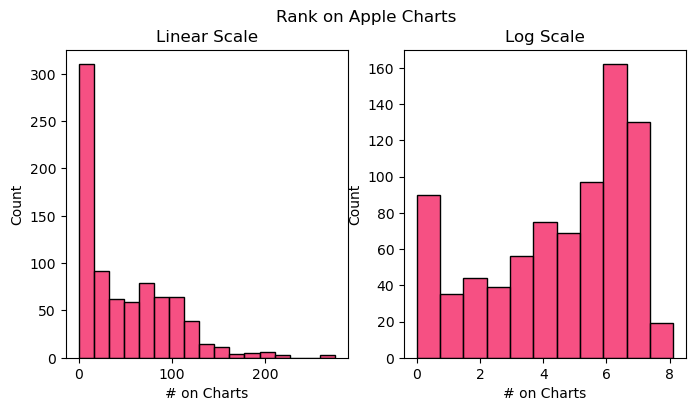

In [203]:
# IN APPLE CHARTS HIST ANALYSIS: LINEAR VS LOG
fig, axes = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle('Rank on Apple Charts')

# histogram using linear scale
sns.histplot(data['in_apple_charts'],ax=axes[0], color='#F31559')
axes[0].set_xlabel('# on Charts')
axes[0].set_title('Linear Scale')
#before we take log, see if there's any data in the column that's 0
np.where(data['in_apple_charts']==0)[0]
# histogram  using logarithmic scale and adding 1 to all values in column (to avoid divide by 0 in taking logs)
sns.histplot(np.log2(data['in_apple_charts'].add(1)), ax=axes[1], color='#F31559')
axes[1].set_xlabel('# on Charts')
axes[1].set_title('Log Scale')
plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


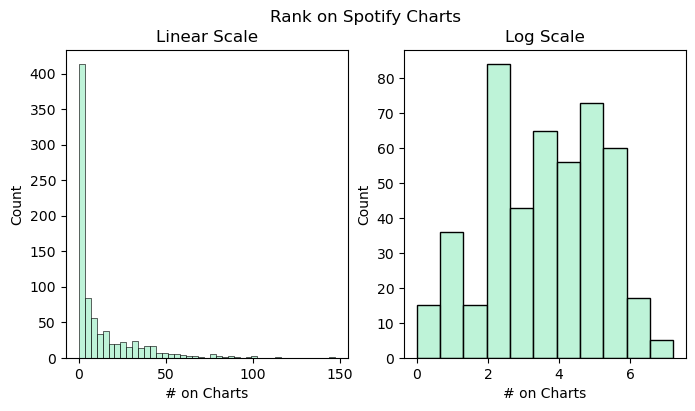

In [204]:
# IN SPOTIFY CHARTS HIST ANALYSIS: LINEAR VS LOG
fig, axes = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle('Rank on Spotify Charts')

# histogram using linear scale
sns.histplot(data['in_spotify_charts'],ax=axes[0], color='#A9EFCB')
axes[0].set_xlabel('# on Charts')
axes[0].set_title('Linear Scale')
# histogram  using logarithmic scale
sns.histplot(np.log2(data['in_spotify_charts']), ax=axes[1], color='#A9EFCB')
axes[1].set_xlabel('# on Charts')
axes[1].set_title('Log Scale')
plt.show()

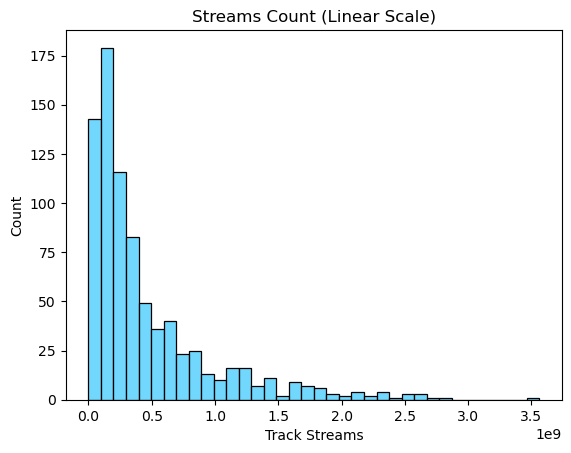

In [205]:
# STREAMS HIST ANALYSIS: histogram of streams using linear scale
sns.histplot(data['streams'], color="#42CAFD")
plt.title("Streams Count (Linear Scale)")
plt.xlabel("Track Streams")
plt.ylabel("Count")
plt.show()

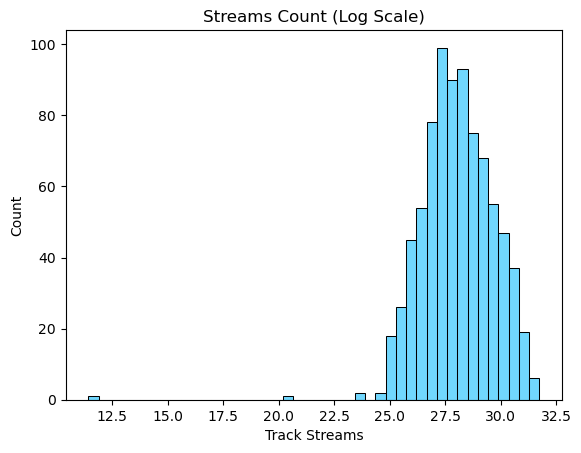

In [206]:
# STREAMS HIST ANALYSIS: histogram of streams using logarithmic scale
sns.histplot(np.log2(data['streams']), color="#42CAFD")
plt.title("Streams Count (Log Scale)")
plt.xlabel("Track Streams")
plt.ylabel("Count")
plt.show()

The histogram of Streams is very skewed right when using a linear scale. When plotted on a log2 scale, the distribution of streams appears more normallly distributed and balanced. However there are a few gaps around 2^12, 2^20, and 2^23.5, which we will remove from the data as it imablances the distribution.

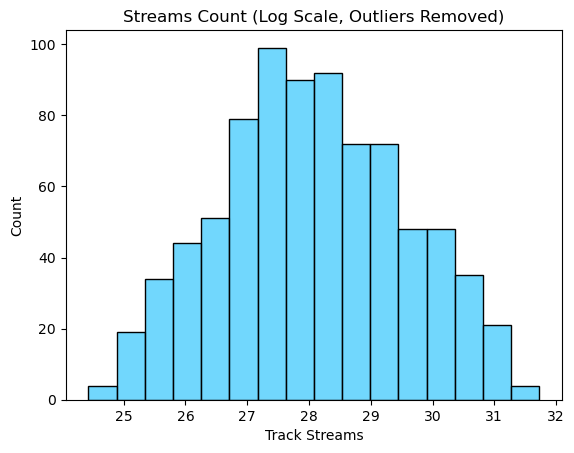

In [207]:
# STREAMS HIST ANALYSIS: regraph histogram of streams using logarithmic scale, with outliers removed
# remove gaps in streams data
data = data.drop(data[np.log2(data.streams) < 24].index)

# check that the outliers were dropped
np.where(np.log2(data['streams'])<24)[0]

# regraph histogram of streams using log scale
sns.histplot(np.log2(data['streams']), color="#42CAFD")
plt.title("Streams Count (Log Scale, Outliers Removed)")
plt.xlabel("Track Streams")
plt.ylabel("Count")
plt.show()

We will add 1 to all values of the Apple and Spotify playlist columns, which just shifts the graphs over and avoids divide by zero/infinity errors in scaling and modeling. 

In [208]:
# check for 0s in Spotify and Apple playlists before graphing
# find how many 0s there are in Apple playlists
print(len(np.where(data['in_apple_playlists']<1)[0])) #here, we're indexing out of the copy, but not the acutal dataframe
np.where(data['in_apple_playlists']<1)[0] # check for leftover 0s in spotify playlists

# find how many 0s there are in Spotify playlists
print(len(np.where(data['in_spotify_playlists']<1)[0])) #here, we're indexing out of the copy, but not the acutal dataframe
np.where(data['in_spotify_playlists']<1)[0] # check for leftover 0s in spotify playlists

# add 1 to the Apple playlists column
data['in_apple_playlists'] = data['in_apple_playlists'].add(1)
data['in_spotify_playlists'] = data['in_spotify_playlists'].add(1)
# check for leftover 0s
np.where(data['in_apple_playlists']<1)[0]

19
0


array([], dtype=int64)

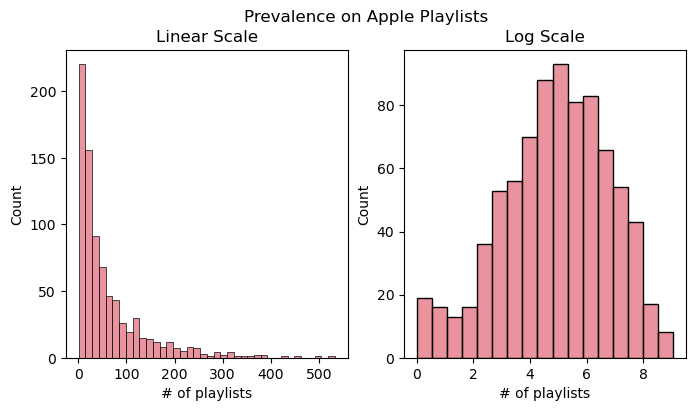

In [209]:
# IN APPLE PLAYLIST HIST ANALYSIS: LINEAR VS LOG
fig, axes = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle('Prevalence on Apple Playlists')

# histogram using linear scale
sns.histplot(data['in_apple_playlists'],ax=axes[0], color="#E16F7C", )
axes[0].set_xlabel('# of playlists')
axes[0].set_title('Linear Scale')
# histogram  using logarithmic scale
sns.histplot(np.log2(data['in_apple_playlists']), ax=axes[1], color="#E16F7C")
axes[1].set_xlabel('# of playlists')
axes[1].set_title('Log Scale')
plt.show()

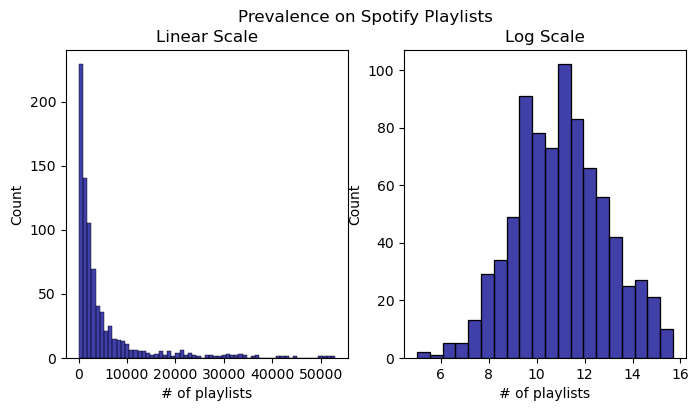

In [210]:
# IN SPOTIFY PLAYLIST HIST ANALYSIS: LINEAR VS LOG
fig, axes = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle('Prevalence on Spotify Playlists')

# histogram of instrumentalness % using linear scale
sns.histplot(data['in_spotify_playlists'],ax=axes[0], color='#00008B', )
axes[0].set_xlabel('# of playlists')
axes[0].set_title('Linear Scale')
# histogram of instrumentalness % using logarithmic scale
sns.histplot(np.log2(data['in_spotify_playlists']), ax=axes[1], color='#00008B')
axes[1].set_xlabel('# of playlists')
axes[1].set_title('Log Scale')
plt.show()

#### Graphs for Track Release Information

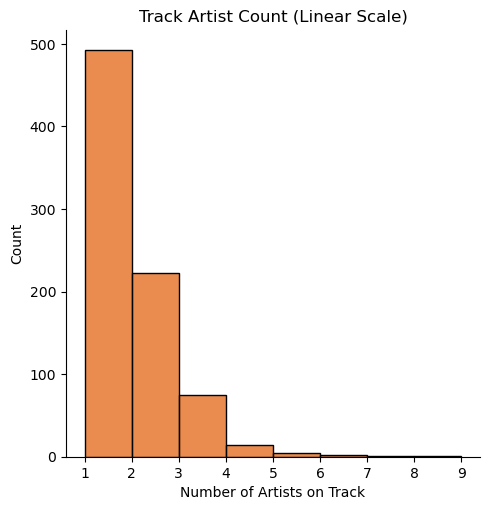

In [211]:
# ARTIST COUNT ANALYSIS: histogram of artist count
sns.displot(data['artist_count'], aspect=1, color='#E36414', bins=np.linspace(1, 9, 9))
plt.title("Track Artist Count (Linear Scale)")
plt.xlabel("Number of Artists on Track")
plt.ylabel("Count")
plt.show()

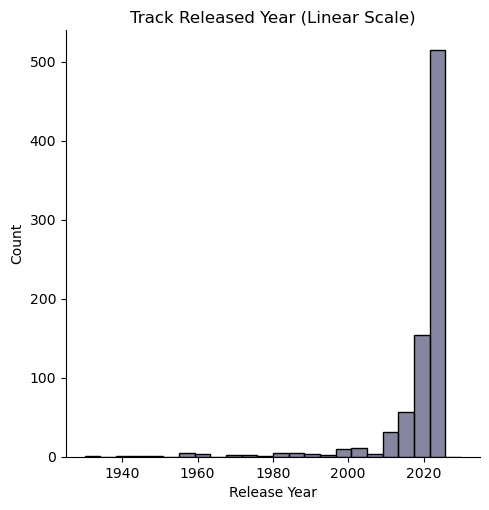

In [212]:
# RELEASE YEAR ANALYSIS: distribution plot of release year
sns.displot(data['released_year'], bins=np.linspace(1930, 2030, 25), color='#5D5D81')
plt.title("Track Released Year (Linear Scale)")
plt.xlabel("Release Year")
plt.ylabel("Count")
plt.show()

#### Graphs for Track Features

Text(0.5, 1.0, 'BPM')

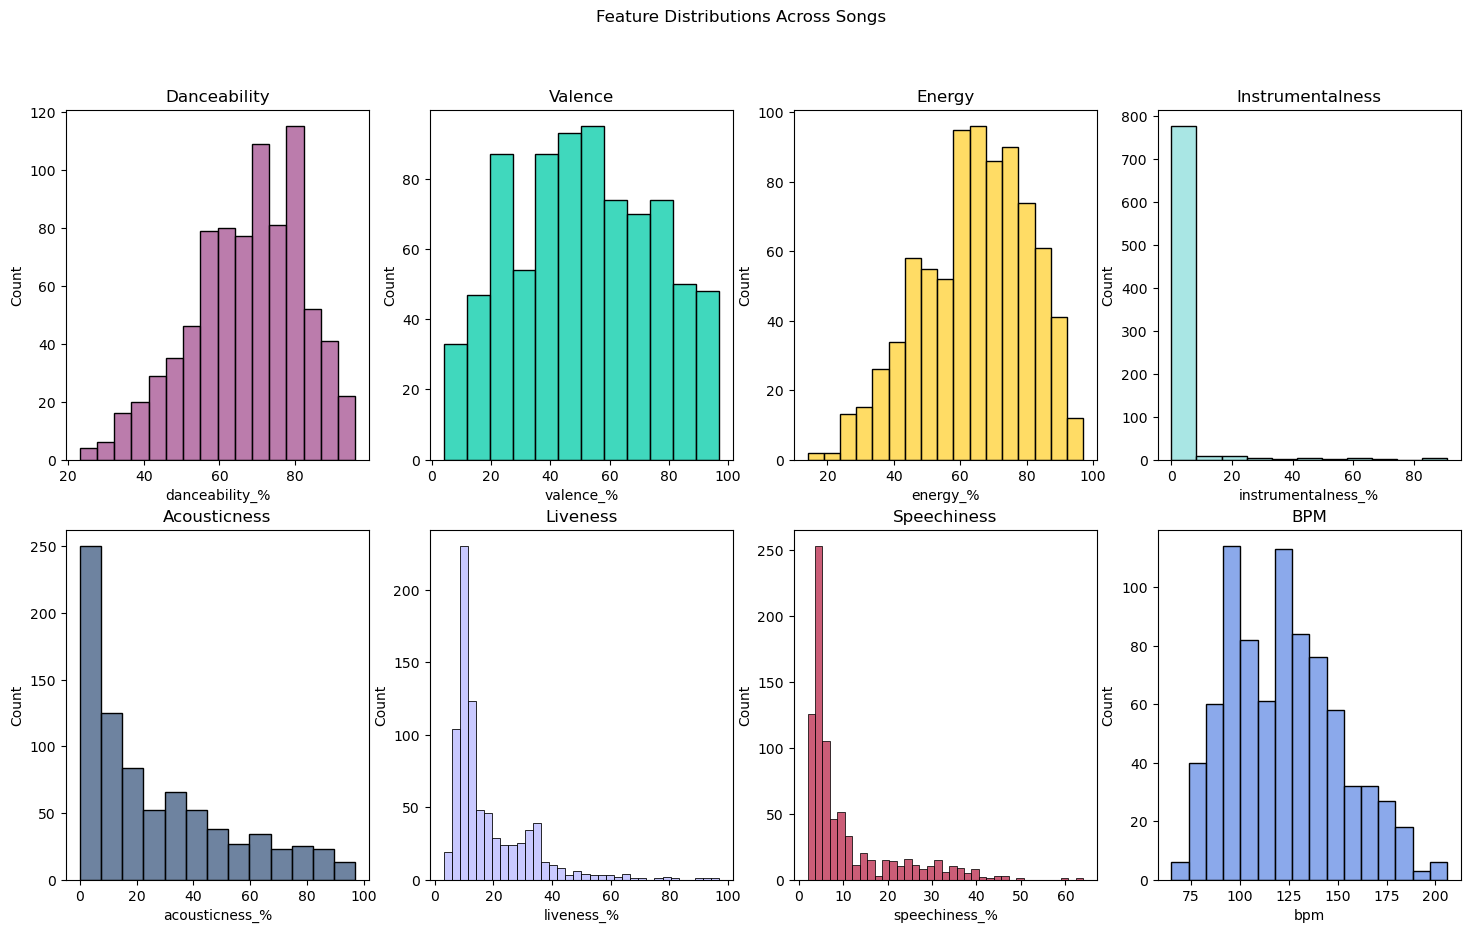

In [213]:
# TRACK FEATURES ANALYSIS: graphing all continuous song features
fig, axes = plt.subplots(2,4, figsize=(18,10))
fig.suptitle('Feature Distributions Across Songs')

sns.histplot(data['danceability_%'],ax=axes[0,0], color='#A55090')
axes[0,0].set_title('Danceability')

sns.histplot(data['valence_%'],ax=axes[0,1], color='#00CCA7')
axes[0, 1].set_title('Valence')

sns.histplot(data['energy_%'],ax=axes[0,2], color='#FFD131')
axes[0, 2].set_title('Energy')

sns.histplot(data['acousticness_%'],ax=axes[1,0], color='#3D5A80')
axes[1,0].set_title('Acousticness')

sns.histplot(data['liveness_%'],ax=axes[1,1], color='#B8B8FF')
axes[1,1].set_title('Liveness')

sns.histplot(data['speechiness_%'],ax=axes[1,2], color='#BA274A')
axes[1,2].set_title('Speechiness')

sns.histplot(data['instrumentalness_%'],ax=axes[0,3], color='#8CDEDC')
axes[0,3].set_title('Instrumentalness')

sns.histplot(data['bpm'], ax=axes[1,3], color='#648DE5')
axes[1,3].set_title('BPM')

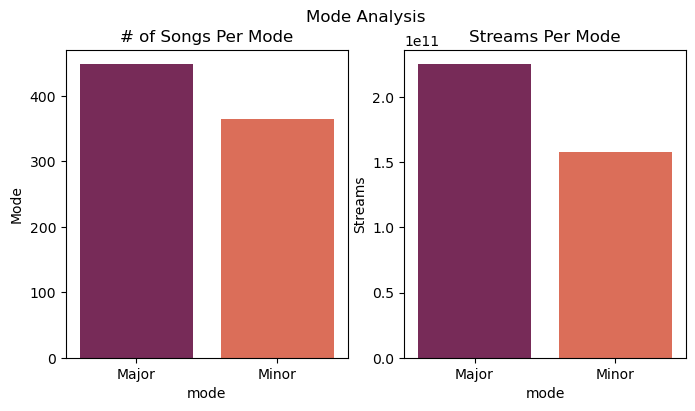

In [214]:
# MODE ANALYSIS
fig, axes = plt.subplots(1,2, figsize=(8,4))
fig.suptitle("Mode Analysis") 

# plot number of songs per mode
sns.countplot(data=data,x='mode',order=data['mode'].value_counts().index, palette='rocket', ax=axes[0])
axes[0].set_title('# of Songs Per Mode')
axes[0].set_ylabel('Mode')

# plot number of streams per mode
spm=data.groupby('mode')['streams'].sum().reset_index().sort_values('streams',ascending=False)
sns.barplot(data=spm, y='streams', x='mode',ax=axes[1], palette='rocket')
axes[1].set_title("Streams Per Mode")
axes[1].set_ylabel("Streams")

plt.show()

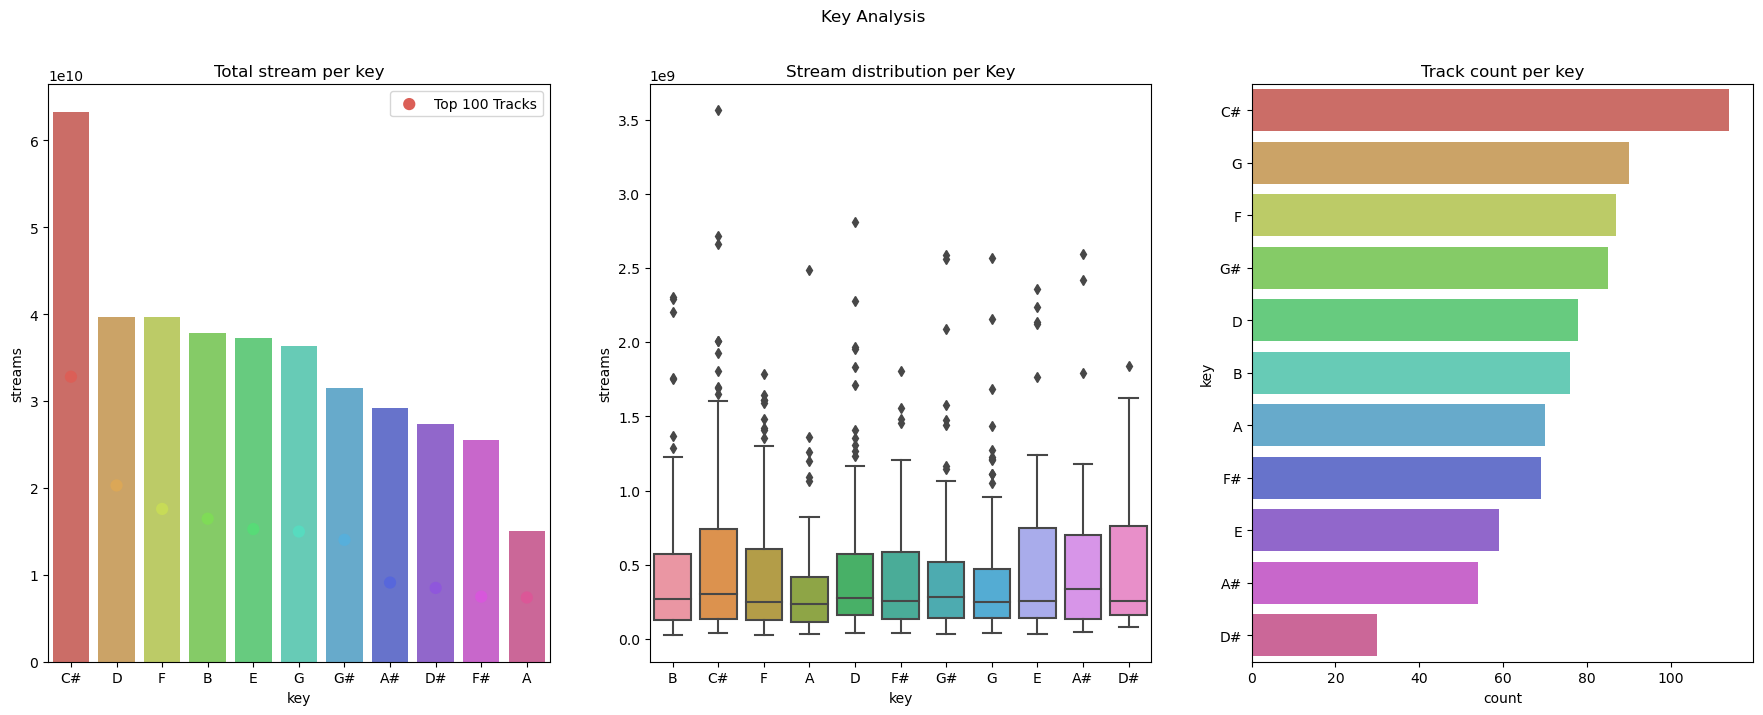

In [215]:
# KEY ANALYSIS: plot categorical variables and compare to streams
fig,ax=plt.subplots(1,3,figsize=(22,7.5))

x=data.groupby('key')['streams'].sum().reset_index().sort_values('streams',ascending=False)
sns.barplot(data=x, y='streams', x='key', palette='hls',ax=ax[0])

y=data.sort_values('streams',ascending=False).head(n=100).groupby('key')['streams'].sum().reset_index().sort_values('streams',ascending=False)
sns.pointplot(data=y, y='streams', x='key',color='blue',label='Top 100 Tracks',palette='hls',ax=ax[0])
ax[0].legend()
ax[0].title.set_text('Total stream per key')

sns.boxplot(data=data, x='key', y='streams',ax=ax[1])
ax[1].title.set_text("Stream distribution per Key")

sns.countplot(data=data,y='key',order=data['key'].value_counts().index, palette='hls',ax=ax[2])
ax[2].title.set_text("Track count per key")

plt.suptitle('Key Analysis')
plt.show()

### Replace performance variables with logs

We are putting track performance variables ‘streams’, ‘in_spotify_playlists’, ‘in_apple_playlists’, ‘in_spotify_charts’, and ‘in_apple_charts’ on a logarithmic scale, because the distributions for each variable appears more normal. To avoid getting an error when taking the log2 of 0 when operating on these variables, we will add 1 to the 'in_apple_charts' and 'in_spotify_charts' variables. It is easier to interpret on a log2 scale rather than the natural log. 

In [216]:
# make dataframe copy of the streams column to keep the raw scores
streams = data[['streams']].copy() 

# add logs of variables to dataframe; replace original columns with logged and +1 values
data['in_apple_charts'] = np.log2(data['in_apple_charts'].add(1))
data['in_spotify_charts'] = np.log2(data['in_spotify_charts'].add(1))
data['streams']= np.log2(data['streams'])
data['in_spotify_playlists']= np.log2(data['in_spotify_playlists'])
data['in_apple_playlists']= np.log2(data['in_apple_playlists'])

### Correlations between continuous variables

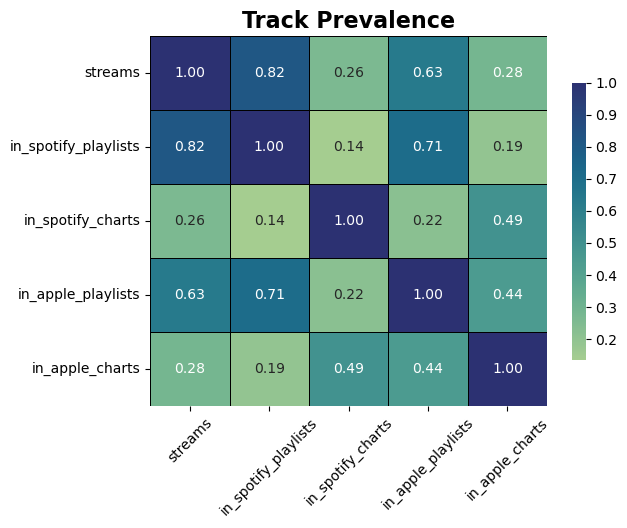

In [217]:
# correlation heatmap of prevalance variables
sns.heatmap(data[['streams', 'in_spotify_playlists', 'in_spotify_charts','in_apple_playlists', 'in_apple_charts']].corr(),annot=True, fmt=".2f", linewidths=0.4, linecolor='black', cmap="crest", cbar=True, cbar_kws={'shrink': 0.75})
plt.title('Track Prevalence', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

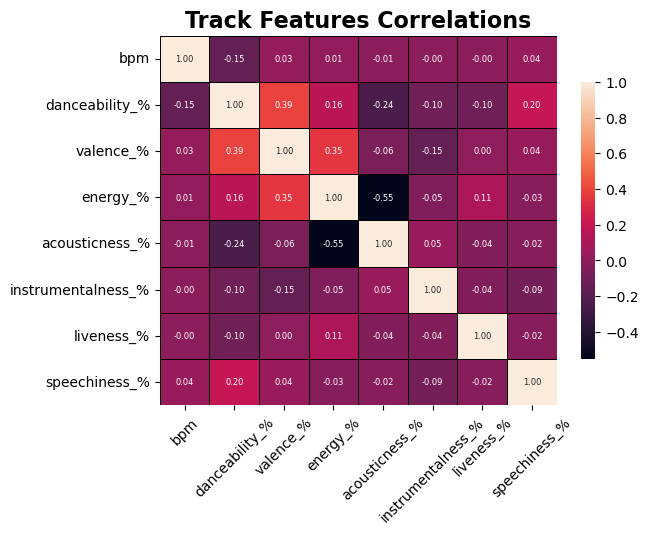

In [218]:
# correlation heatmap of track features
sns.heatmap(data[['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']].corr(),  annot=True, fmt=".2f", linewidths=0.4, linecolor='black', cbar=True, cbar_kws={'shrink': 0.75}, annot_kws={"size":6})
plt.title('Track Features Correlations', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

### Further Exploratory Plots

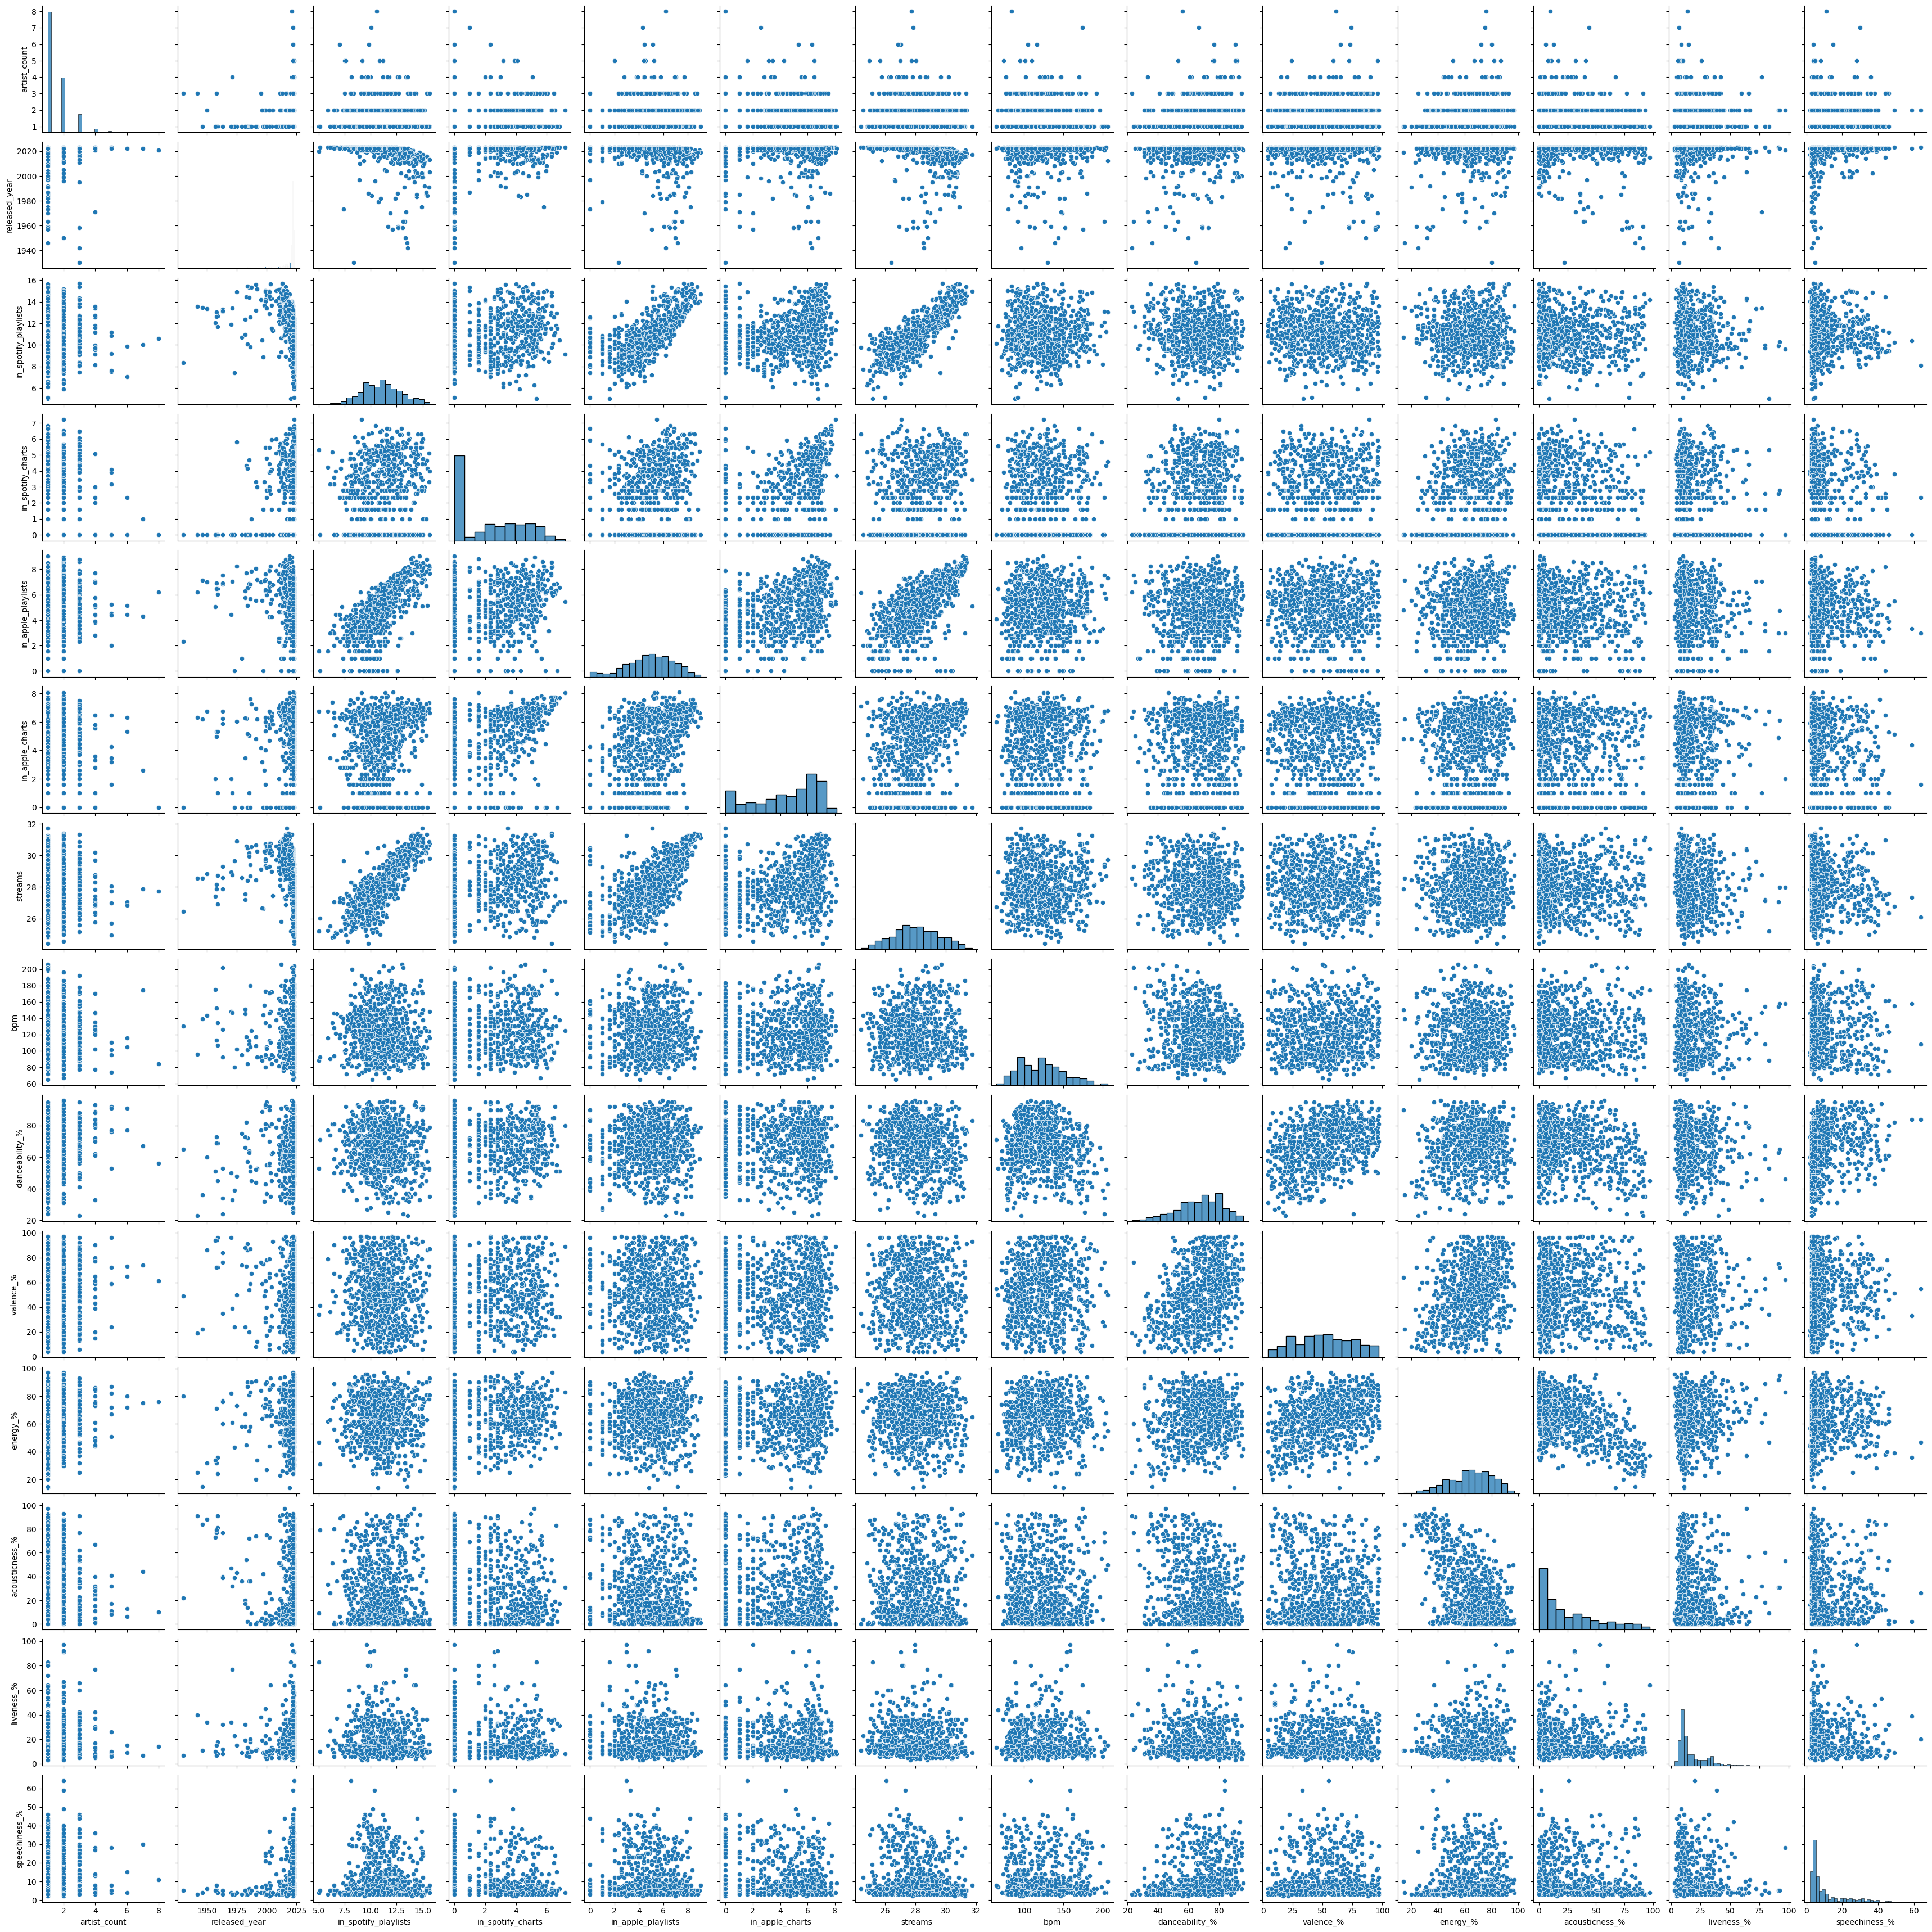

In [219]:
# create a pairplot
sns.pairplot(data[['artist_count', 'released_year', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'streams','bpm','danceability_%','valence_%','energy_%','acousticness_%','liveness_%','speechiness_%']])

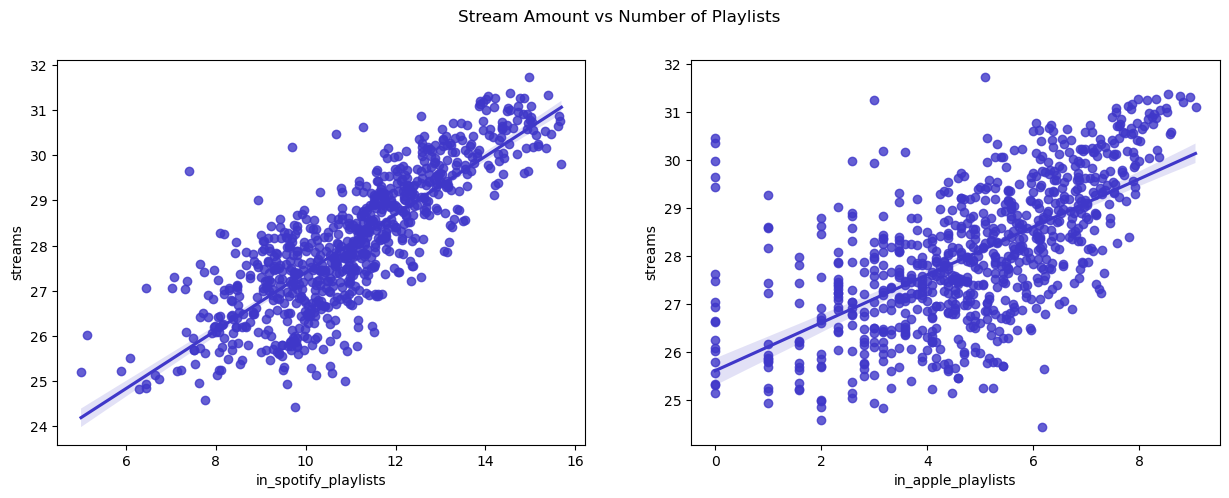

In [220]:
# graph regplot for log streams vs spotify/apple playlists 
cols = ['in_spotify_playlists','in_apple_playlists']
fig, ax = plt.subplots(1,2,figsize=(15,5))
for count, col in enumerate(cols):
    sns.regplot(data=data,x=col, y=data['streams'], ax=ax[count], color='#3F37C9') #changed this to be the variable streams and not the col of the data bc the col was dropped already
plt.suptitle('Stream Amount vs Number of Playlists')
plt.show()

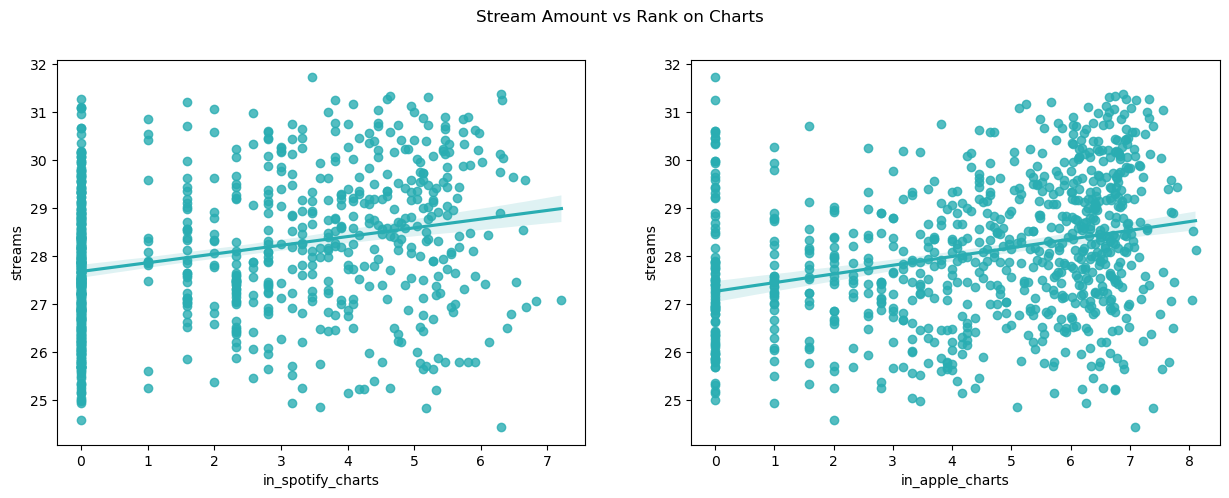

In [221]:
# graph regplot for log streams vs spotify/apple charts 
cols = ['in_spotify_charts','in_apple_charts']
fig, ax = plt.subplots(1,2,figsize=(15,5))
for count, col in enumerate(cols):
    sns.regplot(data=data,x=col, y=data['streams'], ax=ax[count], color='#29ADB2')
plt.suptitle('Stream Amount vs Rank on Charts')
plt.show()

## Update Data and Separate Target/Predictor Variables 

### Modify and drop variables

We are converting the categorical variable ‘key’ to be numerical through categorical encoding. This enables us to graph ‘key’ as a single continuous variable rather than several dummy variables. 

We are dropping the columns that contain the track name, artist name(s), artist count, month, day, the rank on spotify charts, and the rank on apple charts; we are adding their indices to the main dataframe to keep track of their relation to the the features of the song (our predictor variables). 

We are dropping the artist names column because we do not have sufficient/a high enough number of different song data from each artist to be able to determine if the artist name makes a difference in the number of streams.

We are dropping all columns related to Deezer and Shazam because we are not making any predictions about or using these platforms. 

We are also dropping the 'instrumentalness' column because it is highly correlated with acousticness and they are not useful as two separate predictors.

We are converting the categorical variable ‘mode’ to be numerical through pd.get_dummies(). This enables us to graph ‘mode’ as two dummy variables, so we will know if having a Major or Minor mode will affect the song's popularity.

In [222]:
# represent categorical variables numerically with categorical encoding
data = data.replace({"key": {"A": 0, "A#": 1, "B": 2, "C#": 3, "D": 4, "D#": 5, "E": 6, "F": 7, "F#": 8, "G": 9, "G#": 10}})

# copy of indexed columns we want to keep the original of for informational purposes
indexed_columns = data[['track_name','artist(s)_name', 'artist_count', 'released_month', 'released_day', 'in_spotify_charts','in_apple_charts', 'in_spotify_playlists', 'in_apple_playlists', 'streams']].copy() #for index reference

# index names for columns we're dropping
data.index.name = 'track_name','artist(s)_name', 'artist_count', 'released_month', 'released_day', 'in_spotify_charts','in_apple_charts', 'in_spotify_playlists', 'in_apple_playlists', 'streams'

# drop unused variables
data = data.drop(['track_name','artist(s)_name', 'artist_count', 'released_month', 'released_day', 'in_spotify_charts','in_apple_charts', 'instrumentalness_%'], axis=1)

# encode data
data = pd.get_dummies(data)

### Standardize data and add variable

In [223]:
# standardize the encoded spotify data using standard scalar
ss = StandardScaler() # this initializes the StandardScaler 
data = pd.DataFrame(ss.fit_transform(data), columns = data.columns) # new standarized spotify dataframe

# add column of difference between playlists values to use in the 2nd question
data['playlist_differences'] = (data['in_spotify_playlists']) - (data['in_apple_playlists'])
data.head() 

released_year  in_spotify_playlists   streams  in_apple_playlists  \
0       0.420084             -1.012328 -0.668485            0.283587   
1       0.420084             -0.267093 -0.722587            0.366105   
2       0.420084             -0.307896 -0.677989            0.873688   
3       0.046880              1.006106  1.014650            1.033384   
4       0.420084              0.306456  0.072096            0.788414   

        bpm       key  danceability_%  valence_%  energy_%  acousticness_%  \
0  0.087982 -0.980264        0.859725   1.603159  1.156525        0.181390   
1 -1.082606 -0.669458        0.245804   0.418467  0.598902       -0.760001   
2  0.549123  0.573767       -1.118465  -0.808536 -0.702216       -0.367755   
3  1.684239 -1.601876       -0.845611   0.291536  0.474986       -0.603103   
4  0.761957 -1.601876       -0.163477  -1.189330  0.970650       -0.485429   

   liveness_%  speechiness_%  mode_Major  mode_Minor  playlist_differences  
0   -0.749007      -0.639541    0.901388   -0.901388             -1.295915  
1   -0.601387      -0.639541    0.901388   -0.901388             -0.633198  
2    0.948621      -0.443908    0.901388   -0.901388             -1.181583  
3   -0.527577       0.436439    0.901388   -0.901388             -0.027278  
4   -0.527577      -0.443908   -1.109400    1.109400             -0.481957

## Research question 1: Can we predict how many streams on Spotify a song has based on its patterns of audio features (bpm, key, danceability, valence, energy, acousticness, liveliness, speechiness, and mode)?

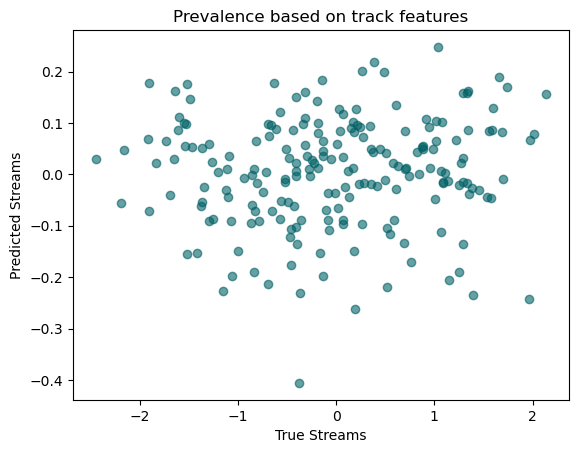

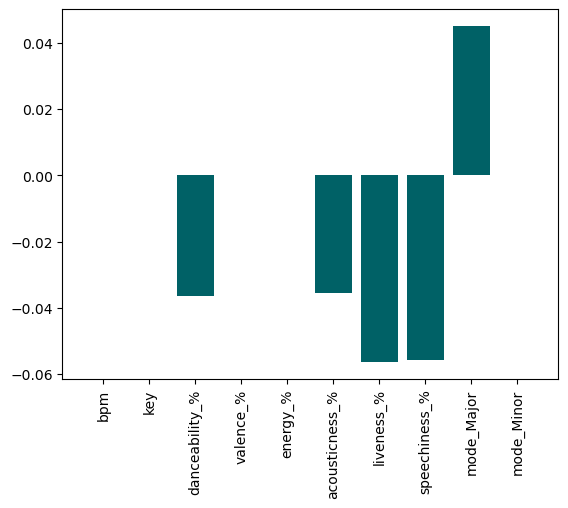

In [224]:
# linear regression, lasso, and graphing streams based on features
y = data['streams'] # variable we're predicting
X = data.drop(['released_year','in_spotify_playlists', 'in_apple_playlists','streams', 'playlist_differences'], axis=1).astype('float64')
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 16,shuffle=True) # split data into training and test sets

# build a standard scalar model from the training set
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# the lasso
lassocv = LassoCV(alphas=None, cv=5, max_iter=10000)
lassocv.fit(X_train, y_train)
lasso = Lasso(max_iter = 10000)
lasso.set_params(alpha=lassocv.alpha_) #test model using model's alpha parameter
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
lasso.score(X_train,y_train)

# scatterplot of predicted streams vs true streams
plt.figure()
plt.plot(y_test,y_pred,'o', color='#006166', alpha=.6)
plt.xlabel('True Streams')
plt.ylabel('Predicted Streams')
plt.title('Prevalence based on track features')
plt.show()

# lasso plot of predictors
plt.figure()
plt.bar(X.columns,lasso.coef_, color='#006166')
plt.xticks(rotation= "vertical")
plt.show()

## Research question 2: Can we predict, based on popularity features of a song, which streaming site (Spotify or Apple playlist) it would be more popular on?

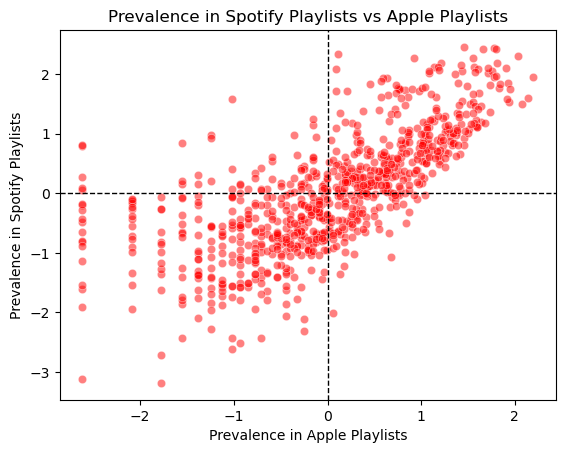

In [225]:
# scatterplot of tracks in apple playlists vs spotify playlists
sns.scatterplot(x="in_apple_playlists", y="in_spotify_playlists", data=data, color="red", alpha=.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Prevalence in Apple Playlists')
plt.ylabel('Prevalence in Spotify Playlists')
plt.title("Prevalence in Spotify Playlists vs Apple Playlists")
plt.show()

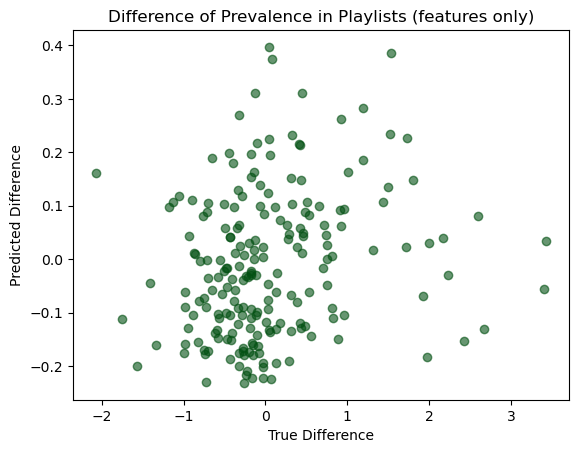

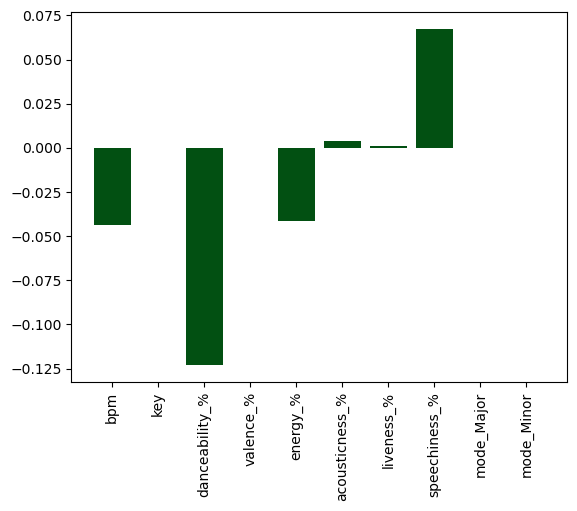

In [226]:
# question 2 continued
# predicting the difference of song prevalence in playlists on either platform based on track features

# multiple linear regression & lasso
y2 = data['playlist_differences']
X2 = data.drop(['released_year', 'playlist_differences', 'in_spotify_playlists', 'in_apple_playlists', 'streams'], axis=1).astype('float64')

X2_train,X2_test, y2_train,y2_test = train_test_split(X2,y2,test_size = 0.25,random_state = 16,shuffle=True)

X2_train = ss.fit_transform(X2_train)
X2_test = ss.transform(X2_test)

# the lasso
lassocv.fit(X2_train, y2_train)
lasso2 = Lasso(max_iter = 10000)
lasso2.set_params(alpha=lassocv.alpha_)
lasso2.fit(X2_train, y2_train)
y2_pred = lasso2.predict(X2_test)
lasso2.score(X2_train,y2_train)

# scatterplot of predicted playlist difference vs true difference (using features only)
plt.figure()
plt.plot(y2_test,y2_pred,'o', color='#025012', alpha=.6)
plt.xlabel('True Difference')
plt.ylabel('Predicted Difference')
plt.title('Difference of Prevalence in Playlists (features only)')
plt.show()

# lasso plot of predictors
plt.figure()
plt.bar(X2.columns,lasso2.coef_, color='#025012')
plt.xticks(rotation= "vertical")
plt.show()

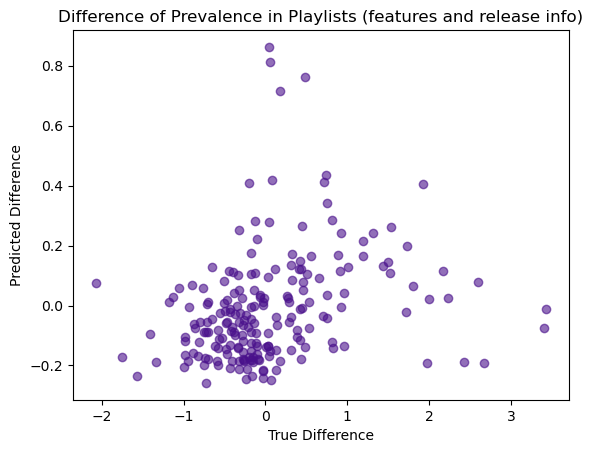

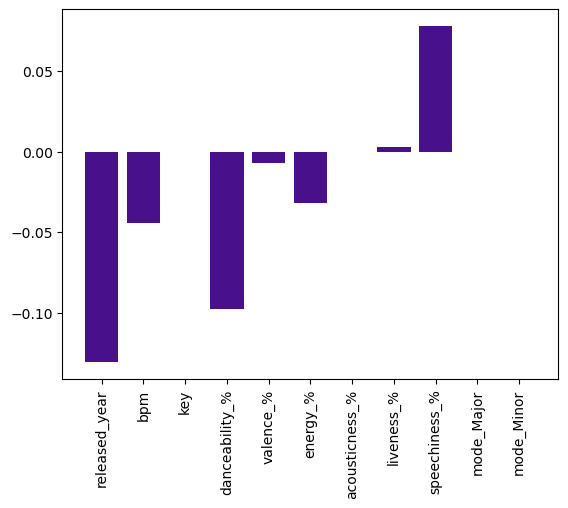

In [227]:
# question 2 continued 
# predicting the difference of song prevalence in playlists on either platform based on track features and release year
y2 = data['playlist_differences']
X2 = data.drop(['playlist_differences', 'in_spotify_playlists', 'in_apple_playlists', 'streams'], axis=1).astype('float64')

X2_train,X2_test, y2_train,y2_test = train_test_split(X2,y2,test_size = 0.25,random_state = 16,shuffle=True)

X2_train = ss.fit_transform(X2_train)
X2_test = ss.transform(X2_test)

# the lasso
lassocv.fit(X2_train, y2_train)
lasso2 = Lasso(max_iter = 10000)
lasso2.set_params(alpha=lassocv.alpha_)
lasso2.fit(X2_train, y2_train)
y2_pred = lasso2.predict(X2_test)
lasso2.score(X2_train,y2_train)

# scatterplot of predicted playlist difference vs true difference (using features and release info)
plt.figure()
plt.plot(y2_test,y2_pred,'o', color='#49108B', alpha=.6)
plt.xlabel('True Difference')
plt.ylabel('Predicted Difference')
plt.title('Difference of Prevalence in Playlists (features and release info)')
plt.show()

# lasso plot of predictors
plt.figure()
plt.bar(X2.columns,lasso2.coef_, color='#49108B')
plt.xticks(rotation= "vertical")
plt.show()

## Research question 3: Are the songs clustered based on the track feature/info?

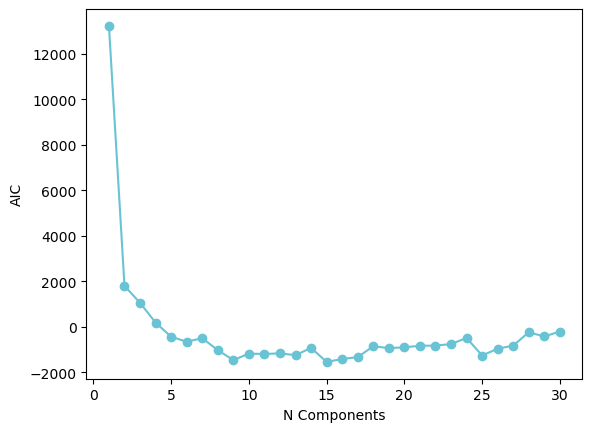

15
True


In [228]:
# predicting the difference of song prevalence in playlists on either platform based on track features and release year
features_info = data.drop(['playlist_differences', 'in_spotify_playlists', 'in_apple_playlists', 'streams'], axis=1).astype('float64')

#compute and plot AIC for n components 
n_components = np.arange(1, 31)
models = [GaussianMixture(n, covariance_type='full', random_state=16)
          for n in n_components]
aics = [model.fit(features_info).aic(features_info) for model in models]
plt.plot(n_components, aics,'o-', color='#68C3D4');
plt.xlabel('N Components')
plt.ylabel('AIC')
plt.show()

min_components = (n_components[np.argmin(aics)])
print(min_components) #gives us the optimal number of components to use 
gmm = GaussianMixture(min_components, covariance_type='full', random_state=16)
gmm.fit(features_info)
print(gmm.converged_)

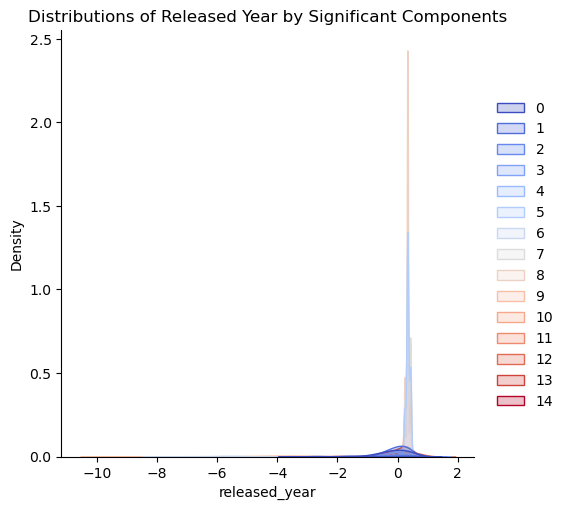

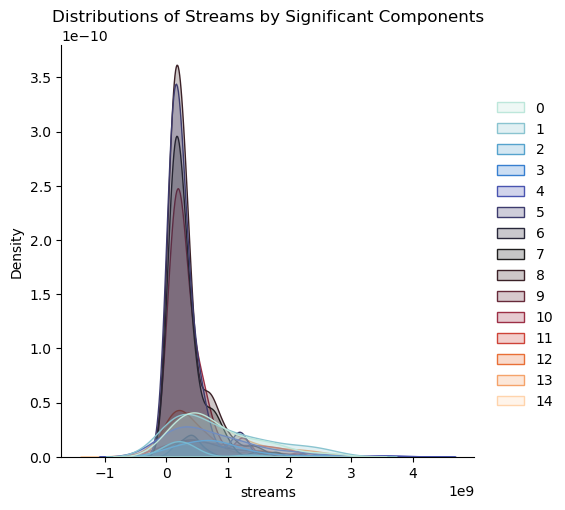

In [229]:
# using Gaussian mixture model based on track features and release year
gmm = GaussianMixture(n_components= min_components, covariance_type='full', random_state=16)
labels_gmm = gmm.fit(features_info).predict(features_info)

# plot released year distribution by components
sns.displot(data=features_info, x='released_year', hue=labels_gmm, kind="kde", fill=True, palette='coolwarm')
plt.title("Distributions of Released Year by Significant Components")
plt.show()

# plot stream distribution by components, using raw stream values
sns.displot(data=streams, x='streams', hue=labels_gmm, kind="kde", fill=True, palette='icefire')
plt.title("Distributions of Streams by Significant Components")
plt.show()

[[-0.26024941  0.06647384 -0.25059576 -0.71308702 -0.34093621  0.36143405
  -0.85499455 -0.55538326 -0.63147169  0.90138782 -0.90138782]
 [-0.08593023 -0.45738752  0.10674112 -0.85977417 -0.69692873 -0.92710383
   1.09742278  0.10513121 -0.49054584  0.90138782 -0.90138782]
 [ 0.03654547  0.24566687 -0.25502548 -0.53486326  0.1223357   0.93625972
  -0.01033369  4.36860523 -0.30259806  0.45451989 -0.45451989]
 [-0.44605135 -0.30834887 -0.11246875  0.15440653  0.80738478  0.64028878
  -0.69354405  0.90823882 -0.33572248 -1.10940039  1.10940039]
 [-0.06081119 -0.26556005 -0.24286384  0.08885365 -0.65277926 -0.84010372
   0.73685723 -0.54912741  0.52447658 -1.10940039  1.10940039]
 [ 0.32820276 -0.03249893 -0.03533917  0.03612564  0.12548449  0.03913226
   0.04104956  0.43863506  0.71205402 -1.10940039  1.10940039]
 [-5.9943565   0.57129302  0.18525883 -1.34868558  0.67761846 -1.98784565
   2.21126396  0.02599708 -0.60285974  0.65003929 -0.65003929]
 [ 0.34117606  0.10004041  0.0749197   0.

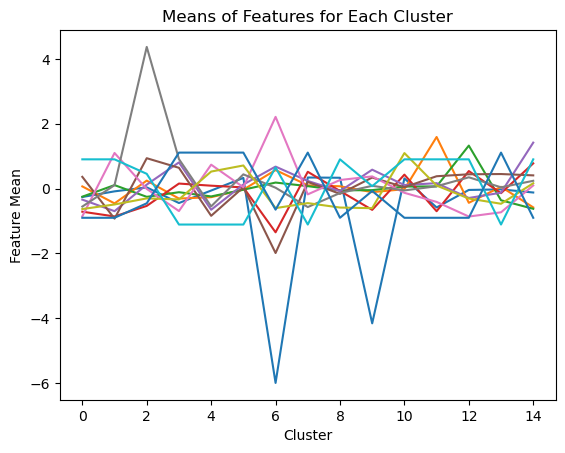

Mean of streams for cluster 0: streams    8.155544e+08
dtype: float64
Mean of streams for cluster 1: streams    8.583254e+08
dtype: float64
Mean of streams for cluster 2: streams    3.303555e+08
dtype: float64
Mean of streams for cluster 3: streams    7.821783e+08
dtype: float64
Mean of streams for cluster 4: streams    7.715496e+08
dtype: float64
Mean of streams for cluster 5: streams    2.845178e+08
dtype: float64
Mean of streams for cluster 6: streams    3.713151e+08
dtype: float64
Mean of streams for cluster 7: streams    3.009964e+08
dtype: float64
Mean of streams for cluster 8: streams    3.110612e+08
dtype: float64
Mean of streams for cluster 9: streams    7.176445e+08
dtype: float64
Mean of streams for cluster 10: streams    3.322257e+08
dtype: float64
Mean of streams for cluster 11: streams    9.079729e+08
dtype: float64
Mean of streams for cluster 12: streams    4.339819e+08
dtype: float64
Mean of streams for cluster 13: streams    7.501370e+08
dtype: float64
Mean of streams 

In [230]:
# calculate mean of features in each cluster
print(gmm.means_) #prints the means values per feature
plt.title("Means of Features for Each Cluster")
plt.plot(gmm.means_)
plt.xlabel('Cluster')
plt.ylabel('Feature Mean')
plt.show()

# calculate the mean of each cluster - using raw streams variable, not logged 
# print the streams mean for each cluster
for i in range(min_components): 
    gmm_means = np.mean(streams[labels_gmm == i], axis=0)
    print(f"Mean of streams for cluster {i}: {gmm_means}")